<h1 align=center><font size = 10>ASM 1</font></h1>

# Bài toán

Trong notebook này, chúng ta sẽ thực hành thuật toán hồi quy tuyến tính mà chúng ta đã học trong khóa học này.

Hãy tải tập dữ liệu bằng cách sử dụng thư viện Pandas và áp dụng thuật toán sau rồi tìm ra thuật toán tốt nhất cho tập dữ liệu cụ thể này bằng các phương pháp đánh giá độ chính xác.

Tập dữ liệu và bài toán thuộc dạng hồi quy cổ điển. Với một số phần tử có một vài đặc điểm (đặc trưng) nhất định, chúng ta cần xây dựng một mô hình ML để xác định **số lượng hồ sơ được chấp nhận**.

Để giải quyết bài toán này, chúng ta cần phân tích dữ liệu, thực hiện bất kỳ chuyển đổi và chuẩn hóa cần thiết nào, áp dụng thuật toán ML, huấn luyện mô hình, kiểm tra chất lượng của mô hình đã huấn luyện và lặp lại cho đến khi có được chất lượng cao nhất cho tập dữ liệu của mình.

# Pipeline 

1. Đọc dữ liệu.

2. Tiền xử lý dữ liệu.

3. Trực quan dữ liệu.

4. Chuẩn bị dữ liệu.

5. Xây dựng mô hình hồi quy tuyến tính đơn biến.

6. Xây dựng mô hình hồi quy tuyến tính đa biến.

7. Xây dựng mô hình hồi quy tuyến tính trên toàn bộ đặc trưng để quan sát mối quan hệ giữa các đặc trưng và mục tiêu.

8. Xây dựng mô hình Lasso để lựa chọn đặc trưng tốt nhất cho mục tiêu.

# Tập dữ liệu

Dự án này liên quan đến tập dữ liệu College, trong file College.csv trong thư mục dữ liệu. Nó chứa các biến sau cho 777 trường đại học và cao đẳng khác nhau ở Mỹ:

**Private**: Chỉ báo public/private

**Apps**: Số lượng hồ sơ nhận được

**Accept**: Số lượng sinh viên được chấp thuận

**Enroll**: Số sinh viên mới đăng ký

**Top10perc**: Sinh viên mới từ top 10% lớp trung học

**Top25perc**: Sinh viên mới từ top 25% lớp trung học

**F.Undergrad**: Số sinh viên đại học toàn thời gian

**P.Undergrad**: Số sinh viên đại học bán thời gian

**Outstate**: Học phí ngoại bang

**Room.Board**: Chi phí ăn ở

**Books**: Chi phí giáo trình theo ước tính

**Personal**: Chi tiêu cá nhân theo ước tính

**PhD**: Phần trăm giảng viên có bằng Tiến sĩ

**Terminal**: Phần trăm giảng viên có Terminal degree (bẳng cấp cao nhất trong một lĩnh vực nhất định)

**S.F.Ratio**: Tỷ lệ sinh viên/giảng viên

**perc.alumni**: Phần trăm cựu sinh viên đã quyên góp

**Expend**: Chi phí giảng dạy cho mỗi sinh viên

**Grad.Rate**: Tỷ lệ tốt nghiệp

# Thư viện cần thiết

In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

matplotlib.style.use('ggplot')

# Hàm tiện ích

Phương pháp tiện ích này sẽ giúp vẽ biểu đồ các quan sát thử nghiệm của bạn, so sánh chúng với đường hồi quy và hiển thị hệ số R2.

In [2]:
def drawLine(model, X_test, y_test, title):
    # Hàm vẽ biểu đồ hồi quy khi X_test có 1 đặc trưng
    # và hiển thị hệ số R2
    y_pred = model.predict(X_test)

    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.scatter(X_test, y_test, c='g', marker='o')
    ax.plot(X_test, y_pred, color='orange', linewidth=1, alpha=0.7)
    ax.set_xlabel(title)
    ax.set_ylabel('Accept')

    R2 = r2_score(y_test, y_pred)

    ax.set_title(title + " vs Accept")
    print("R2: " + str(R2))
    print("Intercept(s): ", model.intercept_)

    plt.show()

In [3]:
def drawPlane(model, X_test, y_test, title):
    # Hàm vẽ biểu đồ hồi quy khi X_test có 2 đặc trưng
    # và hiển thị hệ số R2
    fig = plt.figure(figsize=(10,10))
    ax = Axes3D(fig)
    ax.set_zlabel('prediction')

    
    # Chuyển về numpy vì X_test có thể là DataFrame, v.v.
    X_test = np.array(X_test)
    col1 = X_test[:,0]
    col2 = X_test[:,1]

    
    # Lấy giá trị nhỏ nhất và lớn nhất của 2 đặc trưng
    # để vẽ siêu mặt phẳng   
    # do điểm nhỏ nhất và lớn nhất sẽ bao bọc toàn bộ dữ liệu
    x_min, x_max = col1.min(), col1.max()
    y_min, y_max = col2.min(), col2.max()
    x = np.arange(x_min, x_max, (x_max-x_min) / 10)
    y = np.arange(y_min, y_max, (y_max-y_min) / 10)
    x, y = np.meshgrid(x, y)

    
    # Dự đoán để lấy siêu mặt phẳng
    z = model.predict(np.c_[x.ravel(), y.ravel()])
    z = z.reshape(x.shape)

    # Trực quan hóa dữ liệu và vẽ siêu mặt phẳng
    ax.scatter(col1, col2, y_test, c='g', marker='o')
    ax.plot_wireframe(x, y, z, color='orange', alpha=0.7)

    y_pre = model.predict(X_test)
    R2 = r2_score(y_test, y_pre)

    ax.set_title(title)
    print("R2: " + str(R2))
    print("Intercept(s): ", model.intercept_)

    plt.show()

# Task 1: Đọc dữ liệu từ tập dữ liệu College

Chỉ mục là cột tên trường đại học.

In [4]:
# Nhập code của bạn ở đây
df = pd.read_csv("Data/College.csv", index_col=0)
df.head()

,Private,Apps,Accept,Enroll,Top10perc,Top25perc,F.Undergrad,P.Undergrad,Outstate,Room.Board,Books,Personal,PhD,Terminal,S.F.Ratio,perc.alumni,Expend,Grad.Rate
Abilene Christian University,Yes,1660,1232,721,23,52,2885,537,7440,3300,450,2200,70,78,18.1,12,7041,60
Adelphi University,Yes,2186,1924,512,16,29,2683,1227,12280,6450,750,1500,29,30,12.2,16,10527,56
Adrian College,Yes,1428,1097,336,22,50,1036,99,11250,3750,400,1165,53,66,12.9,30,8735,54
Agnes Scott College,Yes,417,349,137,60,89,510,63,12960,5450,450,875,92,97,7.7,37,19016,59
Alaska Pacific University,Yes,193,146,55,16,44,249,869,7560,4120,800,1500,76,72,11.9,2,10922,15


# Task 2: Mã hóa hạng mục 

Sử dụng map() để chuyển đổi cột Private thành {'Yes':1, 'No':0}.

Hầu hết tất cả thuật toán học máy đều không làm việc với dữ liệu chuỗi hoặc hạng mục, do đó cần chuyển đổi những loại dữ liệu này để phù hợp với đầu vào của học máy. Phương thức `.map()` giống như `.apply()`, nhưng thay vì sử dụng lambda/function, bạn chỉ cần cung cấp ánh xạ key:value.

In [5]:
# Nhập code của bạn ở đây
df.Private = df.Private.map({'Yes': 1, 'No': 0})

In [6]:
df.head()

,Private,Apps,Accept,Enroll,Top10perc,Top25perc,F.Undergrad,P.Undergrad,Outstate,Room.Board,Books,Personal,PhD,Terminal,S.F.Ratio,perc.alumni,Expend,Grad.Rate
Abilene Christian University,1,1660,1232,721,23,52,2885,537,7440,3300,450,2200,70,78,18.1,12,7041,60
Adelphi University,1,2186,1924,512,16,29,2683,1227,12280,6450,750,1500,29,30,12.2,16,10527,56
Adrian College,1,1428,1097,336,22,50,1036,99,11250,3750,400,1165,53,66,12.9,30,8735,54
Agnes Scott College,1,417,349,137,60,89,510,63,12960,5450,450,875,92,97,7.7,37,19016,59
Alaska Pacific University,1,193,146,55,16,44,249,869,7560,4120,800,1500,76,72,11.9,2,10922,15


# Task 3: Trực quan ma trận tương quan

Tính toán ma trận trực quan từ DataFrame

In [7]:
# Nhập code của bạn ở đây
corr = df.corr()

Trực quan ma trận trực quan bằng Seaborn

<AxesSubplot:>

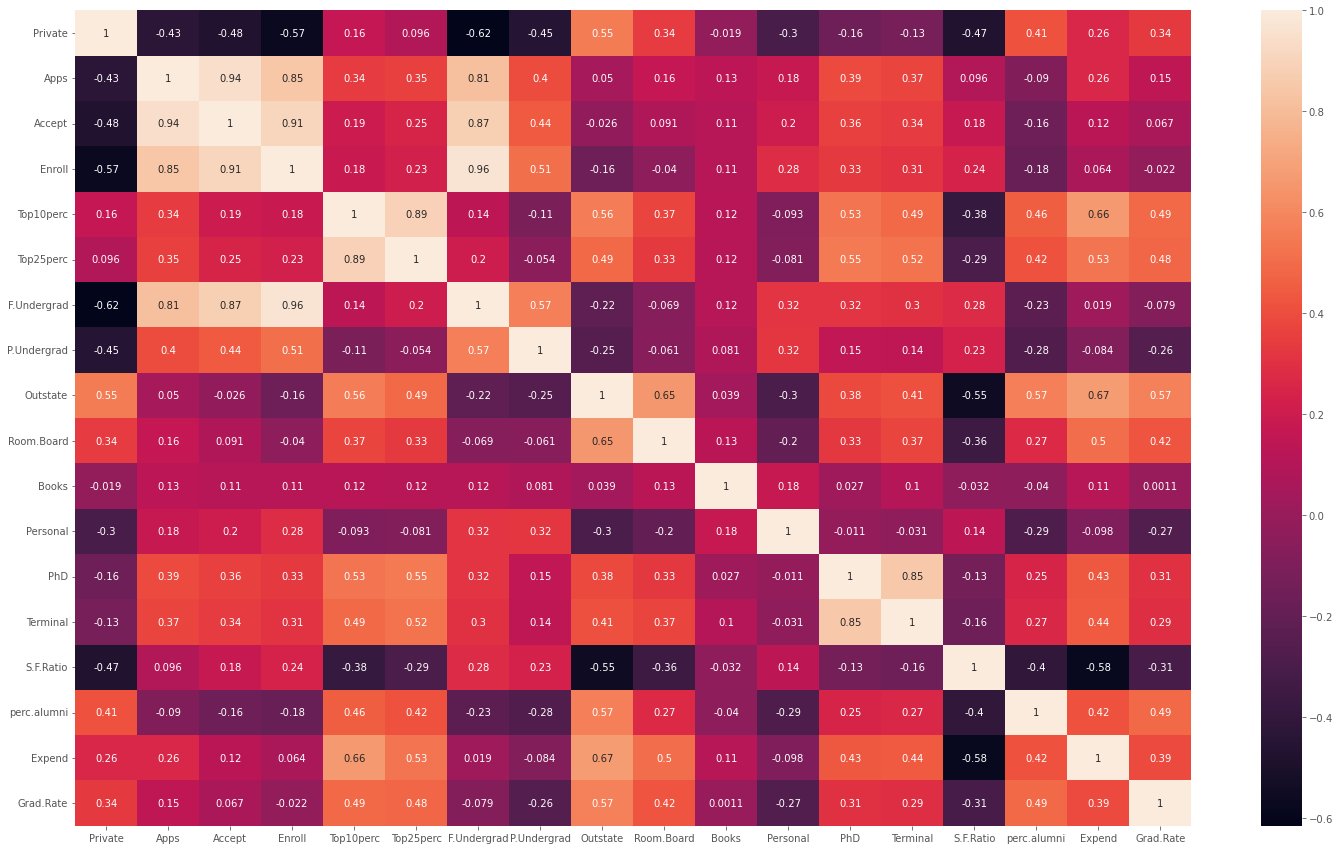

In [8]:
# Nhập code của bạn ở đây
plt.figure(figsize=(25,15))
sns.heatmap(corr, annot=True)

# Task 4: Vẽ biểu đồ Scatter từng đặc trưng với mục tiêu

Lấy ra toàn bộ đặc trưng từ dữ liệu và loại bỏ đi mục tiêu ("Accept")

In [9]:
# Nhập code của bạn ở đây
X_data = df[['Private', 'Apps', 'Enroll', 'Top10perc', 'Top25perc', 'F.Undergrad',
       'P.Undergrad', 'Outstate', 'Room.Board', 'Books', 'Personal', 'PhD',
       'Terminal', 'S.F.Ratio', 'perc.alumni', 'Expend', 'Grad.Rate']]

X_data.columns

Index(['Private', 'Apps', 'Enroll', 'Top10perc', 'Top25perc', 'F.Undergrad',
       'P.Undergrad', 'Outstate', 'Room.Board', 'Books', 'Personal', 'PhD',
       'Terminal', 'S.F.Ratio', 'perc.alumni', 'Expend', 'Grad.Rate'],
      dtype='object')

Trực quan từng đặc trưng với mục tiêu

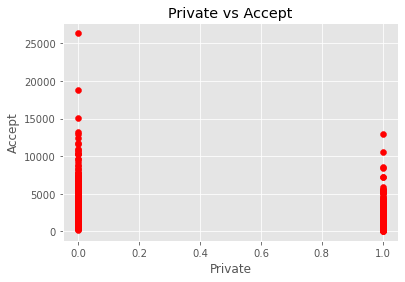

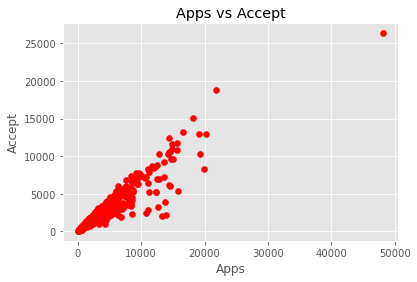

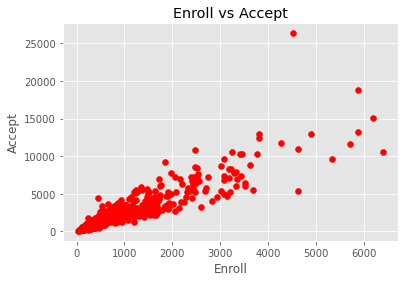

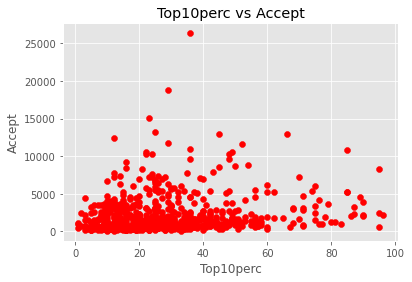

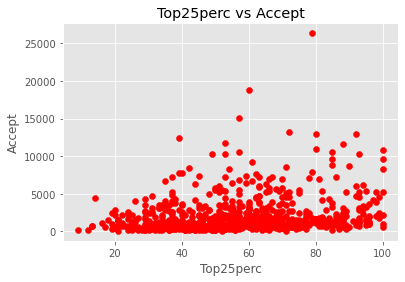

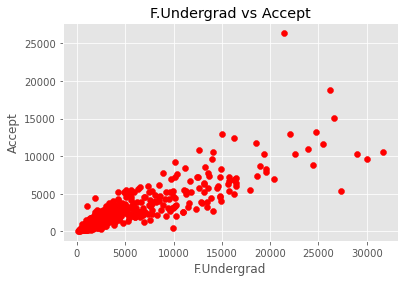

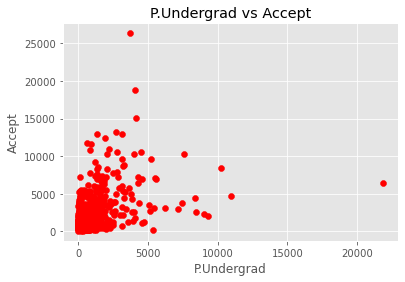

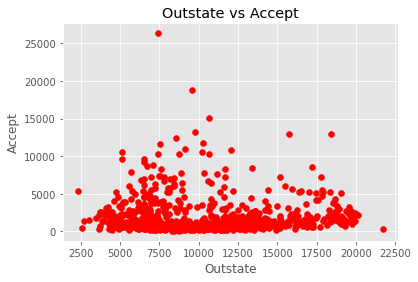

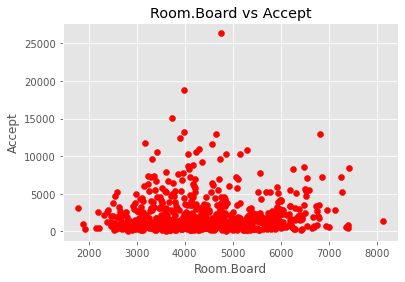

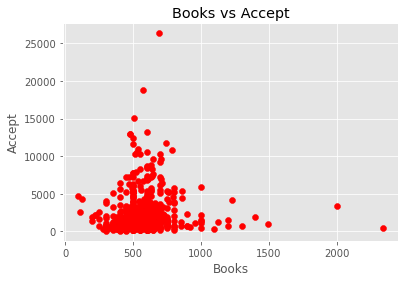

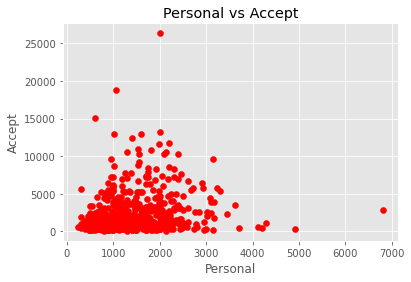

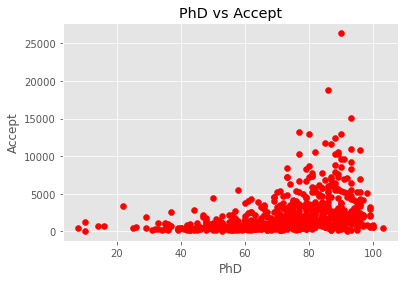

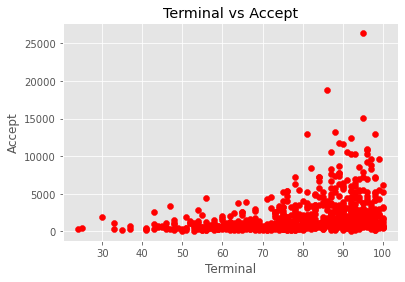

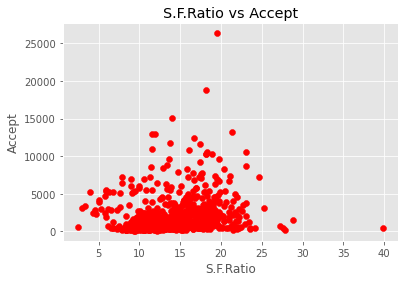

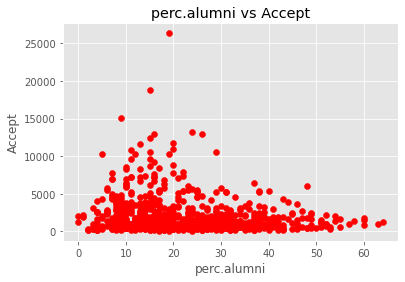

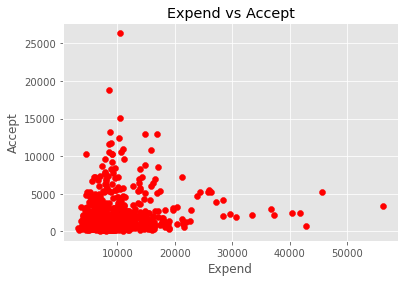

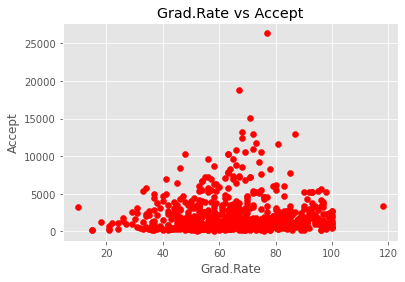

In [10]:
# Nhập code của bạn ở đây
for item in X_data.columns:
    plt.scatter(X_data[item], df.Accept,  color='red')
    plt.xlabel(str(item))
    plt.ylabel("Accept")
    plt.title(str(item) + " vs Accept")

    plt.show()

# Task 5: Phân tách dữ liệu đặc trưng vào X, dữ liệu mục tiêu vào y từ dữ liệu gốc


In [11]:
# Nhập code của bạn ở đây
X = X_data
y = df['Accept']

In [12]:
X.head()

,Private,Apps,Enroll,Top10perc,Top25perc,F.Undergrad,P.Undergrad,Outstate,Room.Board,Books,Personal,PhD,Terminal,S.F.Ratio,perc.alumni,Expend,Grad.Rate
Abilene Christian University,1,1660,721,23,52,2885,537,7440,3300,450,2200,70,78,18.1,12,7041,60
Adelphi University,1,2186,512,16,29,2683,1227,12280,6450,750,1500,29,30,12.2,16,10527,56
Adrian College,1,1428,336,22,50,1036,99,11250,3750,400,1165,53,66,12.9,30,8735,54
Agnes Scott College,1,417,137,60,89,510,63,12960,5450,450,875,92,97,7.7,37,19016,59
Alaska Pacific University,1,193,55,16,44,249,869,7560,4120,800,1500,76,72,11.9,2,10922,15


In [13]:
y.head()

Abilene Christian University    1232
Adelphi University              1924
Adrian College                  1097
Agnes Scott College              349
Alaska Pacific University        146
Name: Accept, dtype: int64

# Task 6: Tách dữ liệu thành train/test data

Dữ liệu train chiếm 70% và random_state là 7.

In [14]:
from sklearn.model_selection import train_test_split

# Nhập code của bạn ở đây
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=7)

In [15]:
X_train

,Private,Apps,Enroll,Top10perc,Top25perc,F.Undergrad,P.Undergrad,Outstate,Room.Board,Books,Personal,PhD,Terminal,S.F.Ratio,perc.alumni,Expend,Grad.Rate
Illinois Wesleyan University,1,3050,471,55,86,1818,23,14360,4090,400,650,77,92,12.9,34,9605,83
Point Park College,1,875,207,7,38,1173,1402,9700,4830,400,1200,45,90,14.5,10,7652,66
Colorado State University,0,9478,2194,29,65,15646,1829,8412,4180,470,1800,87,89,19.2,10,7850,59
Spring Arbor College,1,372,181,15,32,1501,353,8600,3550,385,665,48,48,15.4,9,10938,49
University of Rochester,1,8766,1243,56,75,5071,438,17840,6582,500,882,93,99,5.9,23,26037,80
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Taylor University,1,1769,437,41,80,1757,81,10965,4000,450,1250,60,61,14.2,32,8294,98
Saint Olaf College,1,2248,745,38,73,2888,105,14350,3750,550,550,82,88,10.0,31,12502,83
Southwest State University,0,1047,511,13,33,2091,546,4285,2750,600,1800,58,75,16.5,31,6591,51
Fairfield University,1,4784,781,30,66,2984,1037,15000,6200,700,1100,86,90,15.1,30,11220,94


In [16]:
y_train

Illinois Wesleyan University    1342
Point Park College               744
Colorado State University       6312
Spring Arbor College             362
University of Rochester         5498
                                ... 
Taylor University               1092
Saint Olaf College              1673
Southwest State University       938
Fairfield University            3346
Earlham College                 1006
Name: Accept, Length: 543, dtype: int64

# Task 7: Mô hình hóa hồi quy tuyến tính chi phí ăn ở và số lượng sinh viên được chấp nhận và trực quan mô hình

Tách dữ liệu chi phí ăn ở từ bộ train và test

In [17]:
# Nhập code của bạn ở đây
X_train_rb = X_train['Room.Board']
X_test_rb = X_test['Room.Board']
y_train_rb = y_train
y_test_rb = y_test

Điều chỉnh shape dữ liệu phù hợp với đầu vào của mô hình

Mô hình hồi quy tuyến tính yêu cầu đầu vào có dạng là (m, n) với X và (m, 1) với y.

Trong đó:

- m là số lượng mẫu quan sát

- n là số lượng đặc trưng

Với một đặc trưng duy nhất, shape phù hợp sẽ là (m, 1) cho X.

In [18]:
X_train_rb.shape

(543,)

In [19]:
y_train.shape

(543,)

Xây dựng và huấn luyện mô hình

In [20]:
from sklearn import linear_model
model_1 = linear_model.LinearRegression()

train_x = np.array(X_train_rb).reshape(-1,1)
train_y = np.array(y_train_rb).reshape(-1,1)

model_1.fit(train_x, train_y)

LinearRegression()

Đánh giá chất lượng mô hình bằng chỉ số R2 cho tập test

In [21]:
from sklearn.metrics import r2_score

test_x = np.array(X_test_rb).reshape(-1,1)
test_y = np.array(y_test_rb).reshape(-1,1)
test_y_ = model_1.predict(test_x)

In [22]:
print("R2-score: %f" % r2_score(test_y , test_y_) )

R2-score: -0.002667


Trực quan mô hình hóa với dữ liệu test

R2: -0.0026669864145500988
Intercept(s):  [1340.61956519]


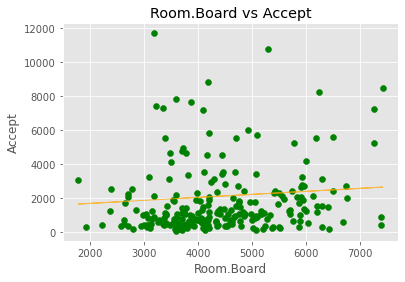

In [23]:
# Nhập code của bạn ở đây
drawLine(model_1, test_x, test_y, "Room.Board")

# Task 8: Mô hình hóa hồi quy tuyến tính số lượng sinh viên ghi danh cho mỗi trường đại học và số lượng sinh viên được chấp nhận và trực quan mô hình

Tách dữ liệu số lượng sinh viên ghi danh cho mỗi trường đại học ở từ bộ train và test

In [24]:
# Nhập code của bạn ở đây
X_train_er = X_train["Enroll"]
X_test_er = X_test['Enroll']
y_train_er = y_train
y_test_er = y_test

Điều chỉnh shape phù hợp với đầu vào của mô hình

In [25]:
# Nhập code của bạn ở đây
train_x = np.array(X_train_er).reshape(-1,1)
train_y = np.array(y_train_er).reshape(-1,1)
test_x = np.array(X_test_er).reshape(-1,1)
test_y = np.array(y_test_er).reshape(-1,1)

Xây dựng và huấn luyện mô hình

In [26]:
# Nhập code của bạn ở đây
model_2 = linear_model.LinearRegression()
model_2.fit(train_x, train_y)

LinearRegression()

Đánh giá chất lượng mô hình bằng chỉ số R2 cho tập test

In [27]:
# Nhập code của bạn ở đây
test_y_ = model_2.predict(test_x)
print("R2-score: %f" % r2_score(test_y , test_y_) )

R2-score: 0.857820


Trực quan mô hình với dữ liệu test

R2: 0.8578204867356156
Intercept(s):  [151.72611242]


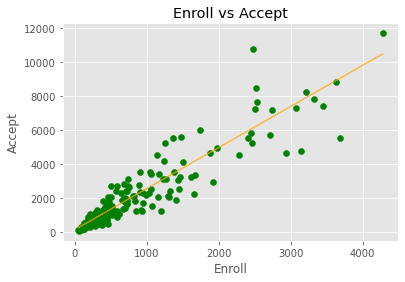

In [28]:
# Nhập code của bạn ở đây
drawLine(model_2, test_x, test_y, "Enroll")

# Task 9: Mô hình hóa hồi quy tuyến tính từng đặc trưng với số lượng sinh viên được chấp nhận và trực quan hóa mô hình với dữ liệu test

Lưu ý: Sử dụng vòng lặp

R2: 0.22400751013309916
Intercept(s):  [4082.93421053]


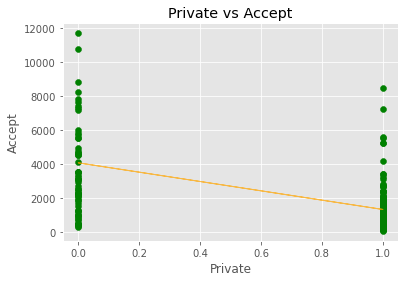

R2: 0.8278338672174985
Intercept(s):  [215.66921084]


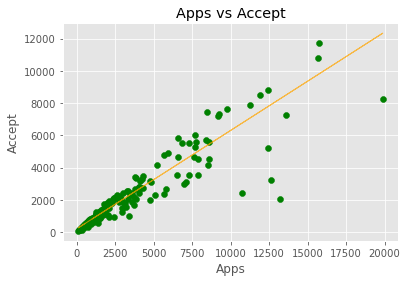

R2: 0.8578204867356156
Intercept(s):  [151.72611242]


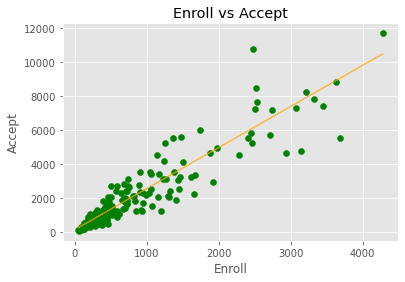

R2: 0.04653179053543455
Intercept(s):  [1397.3784276]


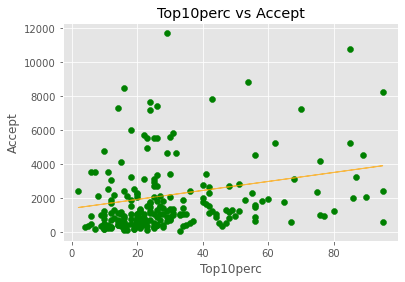

R2: 0.05631647635294579
Intercept(s):  [378.88468283]


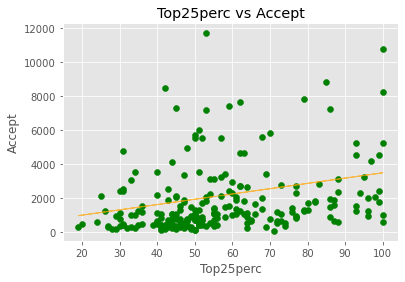

R2: 0.7779917973754006
Intercept(s):  [380.9429105]


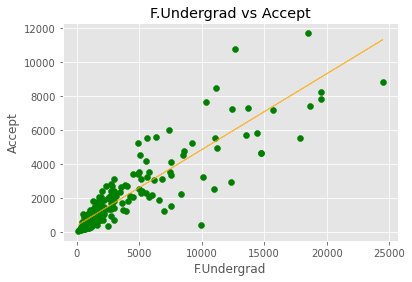

R2: 0.15365724454940077
Intercept(s):  [1444.34815175]


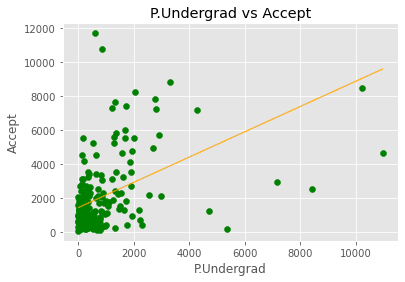

R2: -0.03441717957246193
Intercept(s):  [2472.29781157]


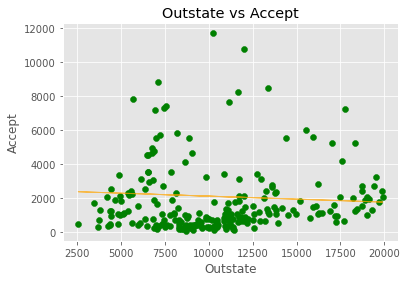

R2: -0.0026669864145500988
Intercept(s):  [1340.61956519]


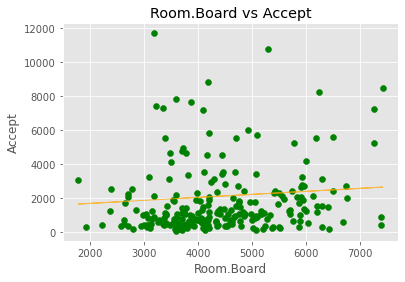

R2: 0.012015078321136241
Intercept(s):  [1304.83559562]


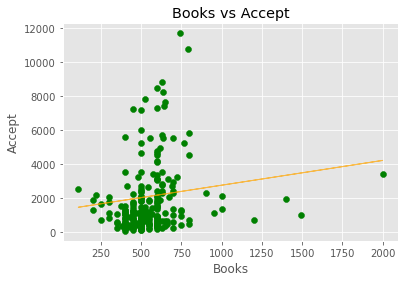

R2: 0.053082024881150325
Intercept(s):  [1185.97560794]


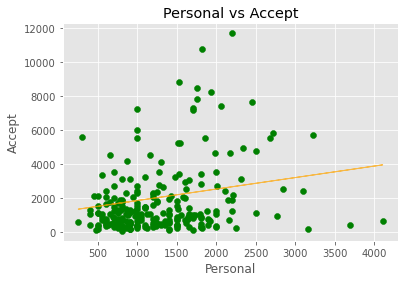

R2: 0.14442475831652213
Intercept(s):  [-1901.73568255]


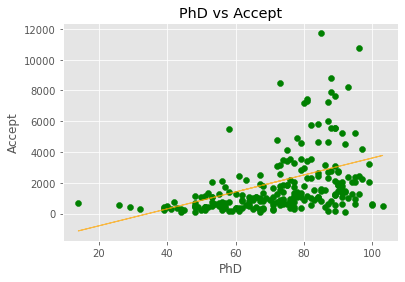

R2: 0.10721305445042717
Intercept(s):  [-2566.34112301]


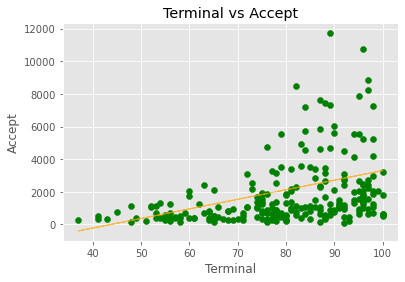

R2: -0.0012154874950456307
Intercept(s):  [406.08920302]


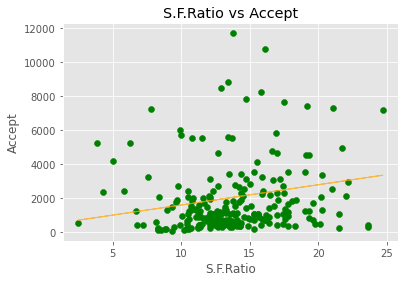

R2: 0.006075121043538134
Intercept(s):  [2869.31957079]


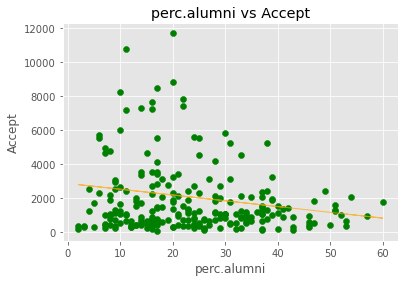

R2: 0.019419509650065114
Intercept(s):  [1652.51677722]


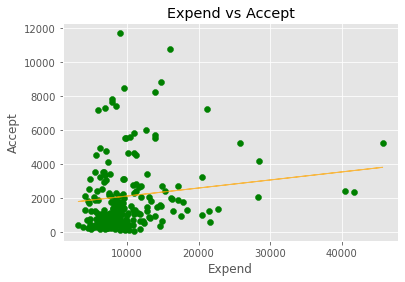

R2: -0.018954776268819362
Intercept(s):  [1407.49746019]


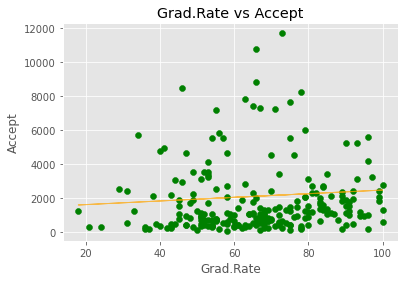

In [29]:
# Nhập code của bạn ở đây
for item in X_train.columns:
    X_train_item = X_train[item]
    X_test_item = X_test[item]
    
    train_x = np.array(X_train_item).reshape(-1,1)
    train_y = np.array(y_train).reshape(-1,1)
    test_x = np.array(X_test_item).reshape(-1,1)
    test_y = np.array(y_test).reshape(-1,1)
    
    model = linear_model.LinearRegression()
    model.fit(train_x, train_y)
    
    drawLine(model, test_x, test_y, str(item))

# Task 10: Mô hình hóa hồi quy tuyến đa biến số lượng sinh viên ghi danh cho mỗi trường đại học và chi phí ăn ở để dự đoán số lượng sinh viên được chấp nhận và trực quan mô hình

Tách dữ liệu số lượng sinh viên ghi danh cho mỗi trường đại học và chi phí ăn ở từ bộ train và test

In [30]:
# Nhập code của bạn ở đây
X_train_er_rb = X_train[["Enroll","Room.Board"]]
X_test_er_rb = X_test[["Enroll","Room.Board"]]
y_train_er_rb = y_train
y_test_er_rb = y_test

Điều chỉnh shape phù hợp với đầu vào của mô hình. 

Lưu ý dữ liệu của chúng ta ở phần này là 2 đặc trưng, do đó đầu vào của mô hình đối với X sẽ là (m, 2)

In [31]:
# Nhập code của bạn ở đây
train_x = np.asanyarray(X_train_er_rb)
train_y = np.array(y_train_er_rb).reshape(-1,1)
test_x = np.asanyarray(X_test_er_rb)
test_y = np.array(y_test_er_rb).reshape(-1,1)

Xây dựng và huấn luyện mô hình

In [32]:
# Nhập code của bạn ở đây
model_er_rb = linear_model.LinearRegression()
model_er_rb.fit(train_x, train_y)

LinearRegression()

Đánh giá chất lượng mô hình bằng chỉ số R2 cho tập test

In [33]:
# Nhập code của bạn ở đây
test_y_ = model_er_rb.predict(test_x)
print("R2-score: %f" % r2_score(test_y , test_y_) )

R2-score: 0.876437


Trực quan mô hình với dữ liệu test

R2: 0.8764371774214047
Intercept(s):  [-1176.62848249]


/var/folders/3g/k66zmqg90ws58shd9ms6jwyw0000gn/T/ipykernel_5860/2744706318.py:5: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax = Axes3D(fig)


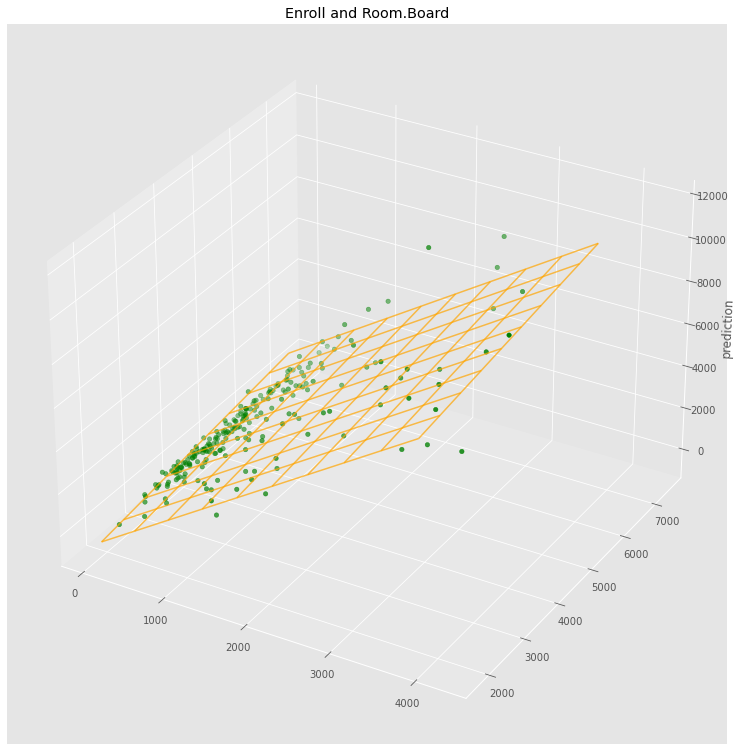

In [34]:
# Nhập code của bạn ở đây
drawPlane(model_er_rb, test_x, test_y, "Enroll and Room.Board")

# Task 11: Sử dụng hồi quy tuyến tính với toàn bộ đặc trưng để quan sát tác động của từng đặc trưng đến mục tiêu

Tạo một bản sao về dữ liệu train và test

In [35]:
# Nhập code của bạn ở đây
X_train_temp = X_train
X_test_temp = X_test
y_train_temp = y_train
y_test_temp = y_test

Điều chỉnh shape phù hợp với đầu vào của mô hình.

Lưu ý rằng đầu vào của mô hình lúc này sẽ là (m, n).

In [36]:
# Nhập code của bạn ở đây
train_x = np.asanyarray(X_train_temp)
train_y = np.array(y_train_temp).reshape(-1,1)
test_x = np.asanyarray(X_test_temp)
test_y = np.array(y_test_temp).reshape(-1,1)

In [37]:
train_x

array([[1.0000e+00, 3.0500e+03, 4.7100e+02, ..., 3.4000e+01, 9.6050e+03,
        8.3000e+01],
       [1.0000e+00, 8.7500e+02, 2.0700e+02, ..., 1.0000e+01, 7.6520e+03,
        6.6000e+01],
       [0.0000e+00, 9.4780e+03, 2.1940e+03, ..., 1.0000e+01, 7.8500e+03,
        5.9000e+01],
       ...,
       [0.0000e+00, 1.0470e+03, 5.1100e+02, ..., 3.1000e+01, 6.5910e+03,
        5.1000e+01],
       [1.0000e+00, 4.7840e+03, 7.8100e+02, ..., 3.0000e+01, 1.1220e+04,
        9.4000e+01],
       [1.0000e+00, 1.3580e+03, 2.7400e+02, ..., 4.6000e+01, 1.4634e+04,
        7.8000e+01]])

Trong hồi quy tuyến tính, đặc trưng có miền giá trị lớn hơn sẽ chiếm ưu thế hơn so với đặc trưng có miền giá trị nhỏ hơn. Để công bằng cho tất cả dặc trưng chúng ta sẽ áp dụng một phương pháp được gọi là co dãn đặc trưng

In [38]:
from sklearn.preprocessing import StandardScaler

# Nhập code của bạn ở đây
train_x_scale = StandardScaler().fit_transform(train_x)
test_x_scale = StandardScaler().fit_transform(test_x)
train_y_scale = StandardScaler().fit_transform(train_y)
test_y_scale = StandardScaler().fit_transform(test_y)

Xây dựng và huấn luyện mô hình

In [39]:
# Nhập code của bạn ở đây
model_scale = linear_model.LinearRegression()
model_scale.fit(train_x_scale, train_y_scale)

LinearRegression()

Đánh giá chất lượng mô hình bằng chỉ số R2 cho tập test

In [40]:
# Nhập code của bạn ở đây
test_y_ = model_scale.predict(test_x_scale)
print("R2-score: %f" % r2_score(test_y_scale , test_y_) )

R2-score: 0.923786


Quan sát tham số với từng đặc trưng để kiểm tra xem đặc trưng nào có tác động mạnh hơn tới số lượng sinh viên được chấp nhận.

Đối chiếu với ma trận trực quan để đối chiếu kết quả, nếu giá trị trong ma trận tương quan là dương lớn thì tham số đối với đặc trưng đó sẽ lớn và ngược lại.

Để hoàn thành được phần này, bạn hãy tham khảo và tìm ra cách lấy tham số cho các đặc trưng từ [LinearRegression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html) của Sklearn

<AxesSubplot:>

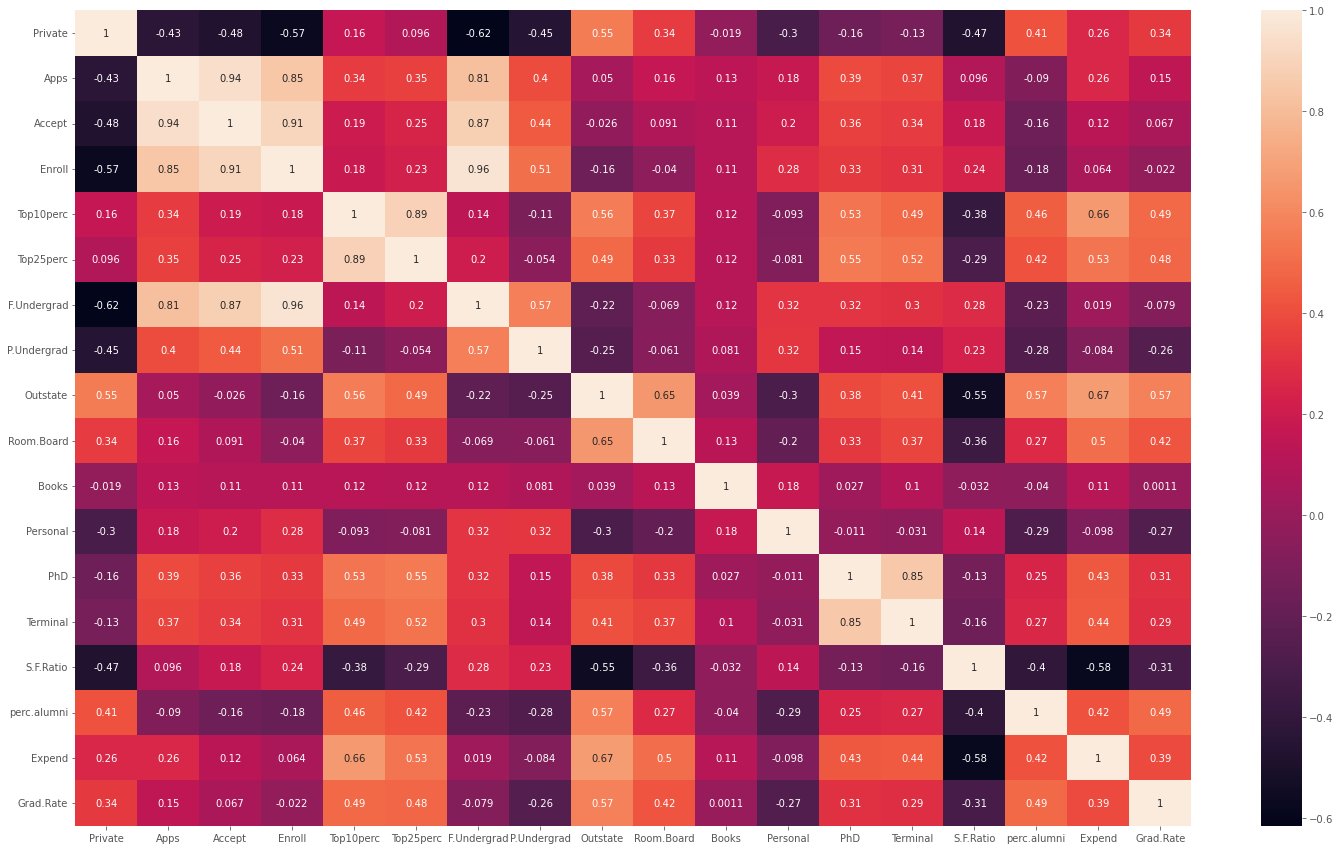

In [41]:
# Nhập code của bạn ở đây
plt.figure(figsize=(25,15))
sns.heatmap(corr, annot=True)

**Câu hỏi: Đặc trưng nào có tác động mạnh nhất đến số lượng sinh viên được chấp nhận ?**

Trả lời: **Đặc trưng tác động mạnh nhất đến số lượng sinh viên được chấp nhận là Apps (Số lượng hồ sơ nhận được) với hệ số tương quan cao nhất bằng 0,94 (có trị tuyệt đối gần bằng 1)**

**Câu hỏi: Đặc trưng nào có tác động ít nhất đến số lượng sinh viên được chấp nhận ?**

Trả lời: **Đặc trưng ít tác động đến số lượng sinh viên được chấp nhận là Outstate (Học phí ngoại bang) với hệ số tương quan bằng -0,026 (có trị tuyệt đối gần 0 nhất)**

# Task 12: Xây dựng mô hình hồi quy tuyến tính của riêng bạn

Tùy ý chọn đặc trưng và điều chỉnh siêu tham số

Yêu cầu: R2 score >= 0.9


In [42]:
X_train_me = X_train[['Apps','Enroll']]
X_test_me = X_test[['Apps','Enroll']]
y_train_me = y_train
y_test_me = y_test

In [43]:
train_x = np.asanyarray(X_train_me)
train_y = np.array(y_train_me).reshape(-1,1)
test_x = np.asanyarray(X_test_me)
test_y = np.array(y_test_me).reshape(-1,1)

In [44]:
# 
train_x_scale = StandardScaler().fit_transform(train_x)
test_x_scale = StandardScaler().fit_transform(test_x)
train_y_scale = StandardScaler().fit_transform(train_y)
test_y_scale = StandardScaler().fit_transform(test_y)

In [45]:
# Nhập code của bạn ở đây
your_model = linear_model.LinearRegression()
your_model.fit(train_x_scale, train_y_scale)

y_pre = your_model.predict(test_x_scale)
print("R2-score: %f" % r2_score(test_y_scale , y_pre) )

R2-score: 0.905679


R2: 0.9056788369756099
Intercept(s):  [-9.56728015e-17]


/var/folders/3g/k66zmqg90ws58shd9ms6jwyw0000gn/T/ipykernel_5860/2744706318.py:5: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax = Axes3D(fig)


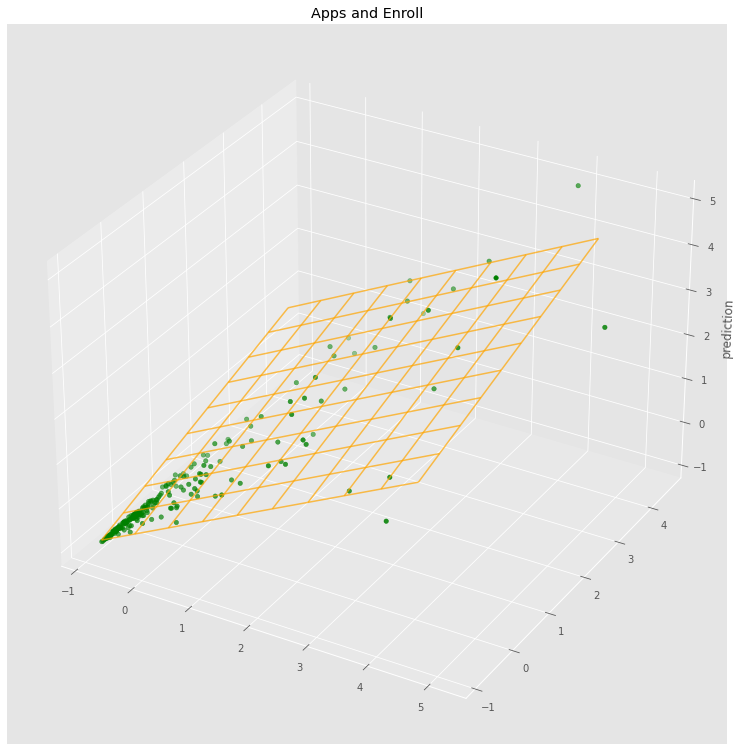

In [46]:
drawPlane(your_model, test_x_scale, test_y_scale, "Apps and Enroll")

**Câu hỏi: Hãy giải thích quá trình lý do lựa chọn đặc trưng, các tham số điều chỉnh để đạt được R2 score >= 0.9**

Trả lời: hai đặc trưng được chọn là `Apps` (Số lượng hồ sơ nhận được) và `Enroll` (Số sinh viên mới đăng ký) để đạt được r2-score >=0,9 bởi vì nhìn vào ma trận tương quan ta thấy hai đặc trưng này có hệ số tương quan dương và đạt giá trị tương quan cao (>= 0,9) lần lượt là 0,94 và 0,91 (có trị tuyệt đối gần bằng 1) so với Accept, cho thấy hay đặc trưng này có môi quan hệ tuyến tính rất mạnh mẽ với Accept

# Task 13: Sử dụng hồi quy Lasso để chọn ra đặc trưng tốt nhất để dự đoán số lượng sinh viên được chấp nhận.

Hồi quy Lasso là hồi quy tuyến tính đặc biệt được tinh chỉnh để có thể đưa các tham số của các đặc trưng không quan trọng tiến về 0 và còn lại các đặc trưng quan trọng.

Alpha càng lớn, tham số của các đặc trưng không quan trọng càng nhỏ và tiến về 0 nhanh.

Yêu cầu: Tìm giá trị alpha sao cho mô hình đạt R2 score >= 9.2

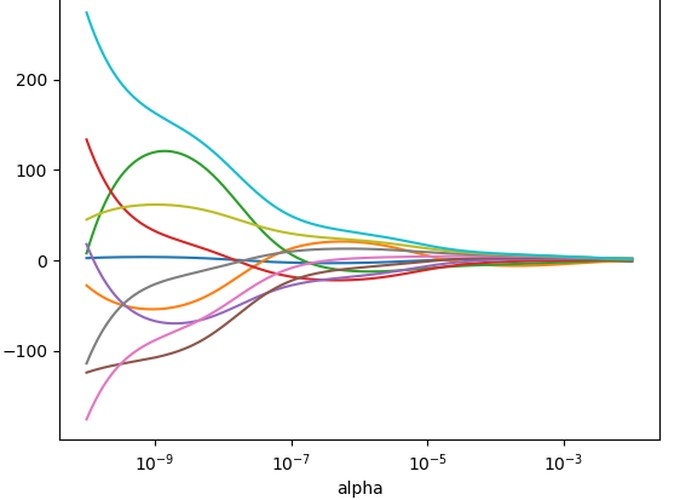

In [47]:
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV

# Nhập code của bạn ở đây
model_lasso = Lasso()
lasso_param = {'alpha': 10.0 ** -np.arange(1, 9)}


gs_lasso = GridSearchCV(estimator=model_lasso,
                        param_grid=lasso_param,
                        scoring='r2')

gs_lasso.fit(X_train, y_train)

y_ = np.array(y_test).reshape(-1,1)
y_pre = gs_lasso.predict(X_test).reshape(-1,1)

Đánh giá chất lượng mô hình bằng chỉ số R2 cho tập test

In [48]:
print("Lasso R2-score: %.2f" % r2_score(y_ , y_pre))

Lasso R2-score: 0.92


Tham số alpha tốt nhất cho hồi quy Lasso

In [49]:
gs_lasso.best_params_

{'alpha': 0.1}

Quan sát tham số với từng đặc trưng để kiểm tra xem đặc trưng nào bị loại bỏ bằng phương pháp Lasso

In [50]:
# Nhập code của bạn ở đây
from sklearn.linear_model import LassoCV

reg_lasso_cv = LassoCV(cv=5, random_state=0).fit(X_train, y_train)

list_coef = reg_lasso_cv.coef_
list_columns = np.array(X_train.columns)

for i in range(0, len(list_coef)):
    print(str(list_columns[i])+ ": " + str(list_coef[i]))

Private: 0.0
Apps: 0.4381499130422842
Enroll: 0.9150016900585238
Top10perc: -0.0
Top25perc: -0.0
F.Undergrad: 0.0
P.Undergrad: -0.0
Outstate: 0.05118458754839405
Room.Board: 0.012509940706914736
Books: -0.0
Personal: -0.0
PhD: -0.0
Terminal: -0.0
S.F.Ratio: -0.0
perc.alumni: -0.0
Expend: -0.060275077506010306
Grad.Rate: -0.0


**Câu hỏi: Đặc trưng nào bị loại bỏ trong hồi quy Lasso ?**

Trả lời (nhấn vào đây để trả lời): Nhìn vào danh sách coef của các đặc trưng ở trên, đặc trưng bị loại bỏ trong Lasso (có giá trị bằng 0) là: `Private`, `Top10perc`, `Top25perc`, `F.Undergrad`, `P.Undergrad`, `Books`, `Personal`, `PhD`, `Terminal`, `S.F.Ratio`, `perc.alumni`, `Grad.Rate`.